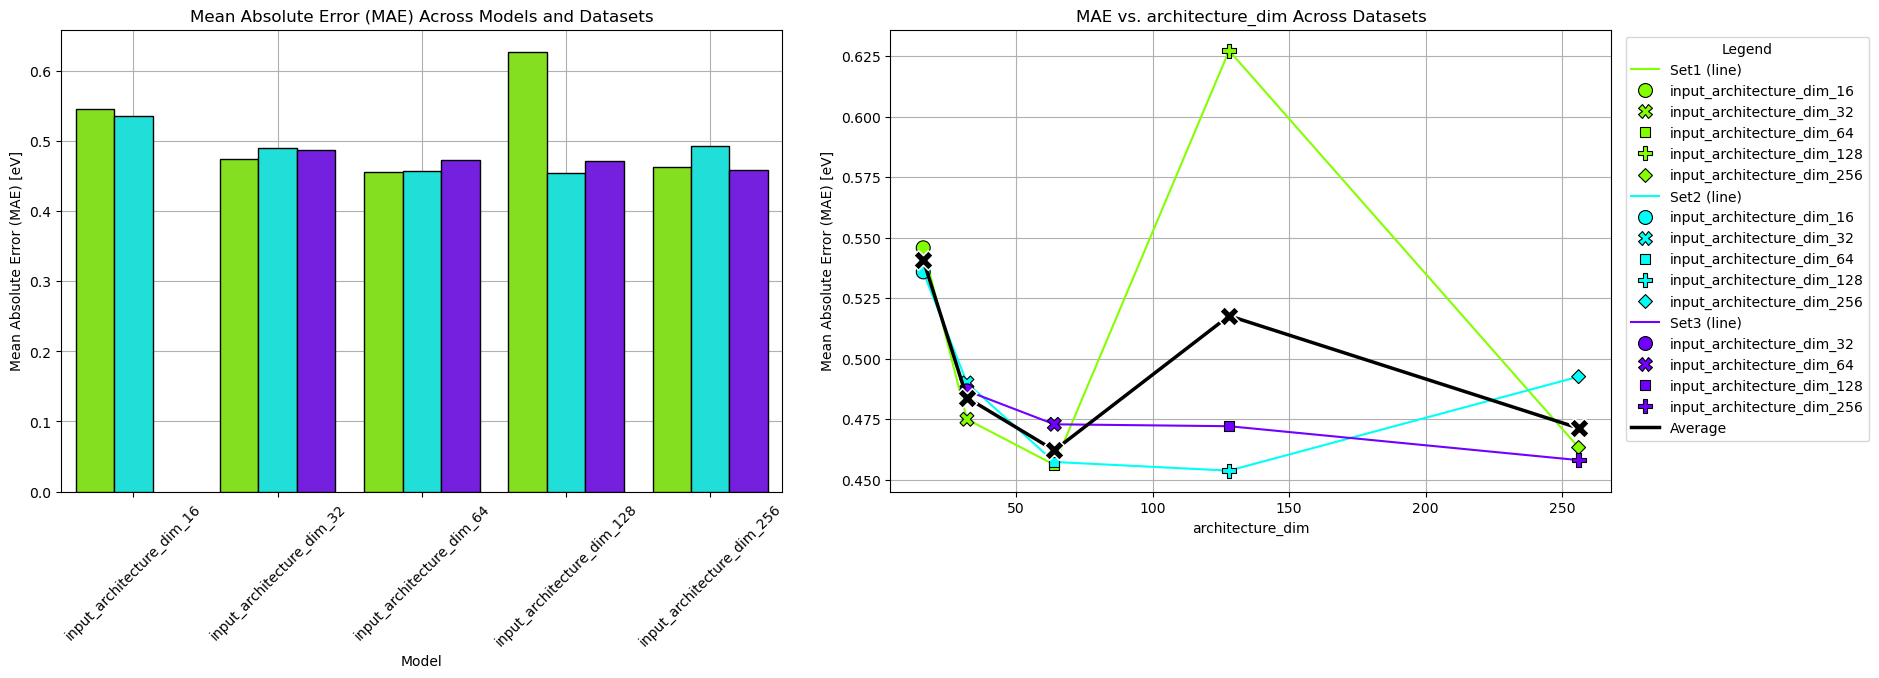

In [247]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ast

root_dir = "/home/tvanhout/oxides_ML/models/hyperparameter_optimization"
datasets = ["Set1", "Set2", "Set3"]  # Add more dataset names as needed
QoI = "architecture_dim"
independent_variable = QoI

all_data = []

for dataset in datasets:
    parent_dir = os.path.join(root_dir, dataset, QoI)
    summary_data = []
    
    for model_folder in os.listdir(parent_dir):
        model_path = os.path.join(parent_dir, model_folder)
        
        if os.path.isdir(model_path):
            summary_entry = {'Dataset': dataset, 'Model': model_folder}

            # Load test set
            test_set_path = os.path.join(model_path, "test_set.csv")
            if os.path.exists(test_set_path):
                df_test = pd.read_csv(test_set_path)
                summary_entry['MAE'] = df_test['Abs_error_eV'].mean()

            # Load hyperparameters from .txt file
            hyperparam_path = os.path.join(model_path, "input.txt")
            if os.path.exists(hyperparam_path):
                with open(hyperparam_path, "r") as file:
                    hyperparams = ast.literal_eval(file.read())

                def flatten_dict(d, parent_key='', sep='_'):
                    items = []
                    for k, v in d.items():
                        new_key = f"{parent_key}{sep}{k}" if parent_key else k
                        if isinstance(v, dict):
                            items.extend(flatten_dict(v, new_key, sep=sep).items())
                        else:
                            items.append((new_key, v))
                    return dict(items)

                flat_hyperparams = flatten_dict(hyperparams)
                summary_entry.update(flat_hyperparams)

            summary_data.append(summary_entry)
    
    df_summary = pd.DataFrame(summary_data)
    all_data.append(df_summary)

# Combine all datasets into a single DataFrame
df_combined = pd.concat(all_data, ignore_index=True)

# Sorting
df_combined = df_combined.sort_values(["Dataset", independent_variable], ascending=True).reset_index()

# Compute the average MAE across the datasets
df_avg = df_combined.groupby([independent_variable], as_index=False)['MAE'].mean()
df_avg['Model'] = 'Average'

# Plot MAE across datasets
plt.figure(figsize=(20, 6))

# First subplot
plt.subplot(1, 2, 1)
sns.barplot(data=df_combined, x='Model', y='MAE', hue='Dataset', palette='hsv', edgecolor='black', legend=False, zorder=10)
plt.title('Mean Absolute Error (MAE) Across Models and Datasets')
plt.ylabel('Mean Absolute Error (MAE) [eV]')
plt.xticks(rotation=45)
plt.grid(True)

# Second subplot
plt.subplot(1, 2, 2)
for i, dataset in enumerate(datasets):
    df_subset = df_combined[df_combined['Dataset'] == dataset].sort_values(by=independent_variable)
    
    # Line connecting points within the dataset
    sns.lineplot(data=df_subset, x=independent_variable, y='MAE', label=f"{dataset} (line)", color=palette[i], linewidth=1.5, zorder=5)
    
    # Scatter plot without custom label (avoid conflict with style)
    sns.scatterplot(data=df_subset, x=independent_variable, y='MAE', style='Model', color=palette[i], s=100, edgecolor='black', zorder=10)

# Plot average line and scatter
df_avg_sorted = df_avg.sort_values(by=independent_variable)
sns.lineplot(data=df_avg_sorted, x=independent_variable, y='MAE', color='black', linewidth=2.5, label='Average', zorder=12)

sns.scatterplot(data=df_avg_sorted, x=independent_variable, y='MAE', color='black', marker='X', s=200, label='_nolegend_', zorder=15
)

plt.xlabel(independent_variable)
plt.ylabel('Mean Absolute Error (MAE) [eV]')
plt.title(f'MAE vs. {independent_variable} Across Datasets')
plt.grid(True)
plt.legend(title='Legend', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.subplots_adjust(wspace=0.15)

if independent_variable == "train_minlr":
    plt.xscale('log')

plt.subplots_adjust(wspace=0.15)
plt.show()


In [248]:
df_combined.loc[df_combined['MAE'].idxmin(), ["Dataset", "Model", independent_variable, "MAE"]]

Dataset                                   Set2
Model               input_architecture_dim_128
architecture_dim                           128
MAE                                   0.453702
Name: 8, dtype: object